In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import textwrap

# 1-Pre-procesamiento

In [ ]:
df = pd.read_csv('dataset/CTG.csv')
df.head()

,FileName,Date,SegFile,b,e,LBE,LB,AC,FM,UC,...,C,D,E,AD,DE,LD,FS,SUSP,CLASS,NSP
0,Variab10.txt,12/1/1996,CTG0001.txt,240.0,357.0,120.0,120.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9.0,2.0
1,Fmcs_1.txt,5/3/1996,CTG0002.txt,5.0,632.0,132.0,132.0,4.0,0.0,4.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0
2,Fmcs_1.txt,5/3/1996,CTG0003.txt,177.0,779.0,133.0,133.0,2.0,0.0,5.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0
3,Fmcs_1.txt,5/3/1996,CTG0004.txt,411.0,1192.0,134.0,134.0,2.0,0.0,6.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0
4,Fmcs_1.txt,5/3/1996,CTG0005.txt,533.0,1147.0,132.0,132.0,4.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0


In [32]:
#corregir tipos de datos
df.Date = pd.to_datetime(df.Date)
mapeo_clases = {
    1.0: "A",
    2.0: "B",
    3.0: "C",
    4.0: "D",
    5.0: "E",
    6.0: "AD",
    7.0: "DE",
    8.0: "LD",
    9.0: "FS",
    10.0: "SUSP"
}
df.CLASS = df.CLASS.map(mapeo_clases).astype('category')
mapeo_nsp = {
    1.0: "Normal",
    2.0: "Sospechoso",
    3.0: "Patológico"
}
df.NSP = df.NSP.map(mapeo_nsp).astype('category')

In [105]:
#removemos DR porque es una columna con 0s
df.drop(columns=['DR'], inplace=True)

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2129 entries, 0 to 2128
Data columns (total 40 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   FileName  2126 non-null   object        
 1   Date      2126 non-null   datetime64[ns]
 2   SegFile   2126 non-null   object        
 3   b         2126 non-null   float64       
 4   e         2126 non-null   float64       
 5   LBE       2126 non-null   float64       
 6   LB        2126 non-null   float64       
 7   AC        2126 non-null   float64       
 8   FM        2127 non-null   float64       
 9   UC        2127 non-null   float64       
 10  ASTV      2127 non-null   float64       
 11  MSTV      2127 non-null   float64       
 12  ALTV      2127 non-null   float64       
 13  MLTV      2127 non-null   float64       
 14  DL        2128 non-null   float64       
 15  DS        2128 non-null   float64       
 16  DP        2128 non-null   float64       
 17  DR        2128

In [35]:
num_columnas = len(df.columns)
umbral = num_columnas  //2

filas_mas_mitad_nulos = df[df.isnull().sum(axis=1) > umbral]
print(filas_mas_mitad_nulos)

     FileName Date SegFile   b   e  LBE  LB  AC     FM    UC  ...   C   D   E  \
2126      NaN  NaT     NaN NaN NaN  NaN NaN NaN    NaN   NaN  ... NaN NaN NaN   
2127      NaN  NaT     NaN NaN NaN  NaN NaN NaN    NaN   NaN  ... NaN NaN NaN   
2128      NaN  NaT     NaN NaN NaN  NaN NaN NaN  564.0  23.0  ... NaN NaN NaN   

      AD  DE  LD  FS  SUSP  CLASS  NSP  
2126 NaN NaN NaN NaN   NaN    NaN  NaN  
2127 NaN NaN NaN NaN   NaN    NaN  NaN  
2128 NaN NaN NaN NaN   NaN    NaN  NaN  

[3 rows x 40 columns]


In [36]:
df.drop(filas_mas_mitad_nulos.index, inplace=True)

In [38]:
#agregar features
df['Tiempo'] = df.e - df.b
columna_e_index = df.columns.get_loc('e')
df.insert(columna_e_index + 1, 'Tiempo', df.pop('Tiempo'))

In [40]:
df.head()

,FileName,Date,SegFile,b,e,Tiempo,LBE,LB,AC,FM,...,C,D,E,AD,DE,LD,FS,SUSP,CLASS,NSP
0,Variab10.txt,1996-12-01,CTG0001.txt,240.0,357.0,117.0,120.0,120.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,FS,Sospechoso
1,Fmcs_1.txt,1996-05-03,CTG0002.txt,5.0,632.0,627.0,132.0,132.0,4.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,AD,Normal
2,Fmcs_1.txt,1996-05-03,CTG0003.txt,177.0,779.0,602.0,133.0,133.0,2.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,AD,Normal
3,Fmcs_1.txt,1996-05-03,CTG0004.txt,411.0,1192.0,781.0,134.0,134.0,2.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,AD,Normal
4,Fmcs_1.txt,1996-05-03,CTG0005.txt,533.0,1147.0,614.0,132.0,132.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,B,Normal


In [44]:
df.isnull().sum().sum()

np.int64(0)

# 2-Análisis Descriptivo

In [79]:
#diccionario de datos para una mejor comprensión de las columnas
descripciones = {
    'FileName': 'FileName: del examen CTG',
    'Date': 'Fecha: del examen',
    'SegFile': 'FileName: SegFile',
    'b': 'b: instante de inicio',
    'e': 'e: instante final',
    'Tiempo': 'Segmento entre e y b',
    'LBE': 'LBE: valor de referencia (perito médico)',
    'LB': 'LB: valor de referencia (SisPorto)',
    'AC': 'AC: aceleraciones (SisPorto)',
    'FM': 'FM: movimiento fetal (SisPorto)',
    'UC': 'UC: contracciones uterinas (SisPorto)',
    'ASTV': 'ASTV: porcentaje de tiempo con variabilidad a corto plazo anormal (SisPorto)',
    'MSTV': 'mSTV: valor medio de la variabilidad a corto plazo (SisPorto)',
    'ALTV': 'ALTV: porcentaje de tiempo con variabilidad anormal a largo plazo (SisPorto)',
    'MLTV': 'mLTV: valor medio de la variabilidad a largo plazo (SisPorto)',
    'DL': 'DL: desaceleraciones leves',
    'DS': 'DS: desaceleraciones graves',
    'DP': 'DP: desaceleraciones prolongadas',
    'DR': 'DR: desaceleraciones repetitivas',
    'Width': 'Anchura: anchura del histograma',
    'Min': 'Min: frecuencia baja del histograma',
    'Max': 'Máx: frecuencia alta del histograma',
    'Nmax': 'Nmáx: número de picos del histograma',
    'Nzeros': 'Nzeros: número de ceros del histograma',
    'Mode': 'Moda: moda del histograma',
    'Mean': 'Media: media del histograma',
    'Median': 'Mediana: mediana del histograma',
    'Variance': 'Varianza: varianza del histograma',
    'Tendency': 'Tendencia: tendencia del histograma: -1 asimétrico a la izquierda; 0-simétrico; 1 asimétrico a la derecha',
    'A': 'A: sueño tranquilo',
    'B': 'B: sueño REM',
    'C': 'C: vigilancia tranquila',
    'D': 'D: vigilancia activa',
    'E': 'SH: patrón de turnos (A o Susp con turnos)',
    'AD': 'AD: patrón acelerativo/decelerativo (situación de estrés)',
    'DE': 'DE: patrón desacelerativo (estimulación vagal)',
    'LD': 'LD: patrón mayoritariamente desacelerativo',
    'FS': 'FS: patrón plano-sinusoidal (estado patológico)',
    'SUSP': 'SUSP: patrón sospechoso',
    'CLASS': 'CLASS: código de clase (1 a 10) para las clases A a SUSP',
    'NSP': 'NSP:- Normal 1; Sospechoso 2; Patológico 3'
}

In [106]:
# Columnas dummy de CLASS a excluir
columnas_dummy = ["A", "B", "C", "D", "E", "AD", "DE", "LD", "FS", "SUSP"]

# Columnas numéricas excluyendo categóricas, datetime y las dummy
numeric_cols_all = df.select_dtypes(include=np.number).columns

# Columnas numéricas excluyendo categóricas, datetime
numeric_cols = df.select_dtypes(include=np.number).columns.difference(columnas_dummy)
print(numeric_cols)

# Columnas categóricas
categorical_cols = df.select_dtypes(include='category').columns
print(categorical_cols)

Index(['AC', 'ALTV', 'ASTV', 'DL', 'DP', 'DS', 'FM', 'LB', 'LBE', 'MLTV',
       'MSTV', 'Max', 'Mean', 'Median', 'Min', 'Mode', 'Nmax', 'Nzeros',
       'Tendency', 'Tiempo', 'UC', 'Variance', 'Width', 'b', 'e'],
      dtype='object')
Index(['CLASS', 'NSP'], dtype='object')


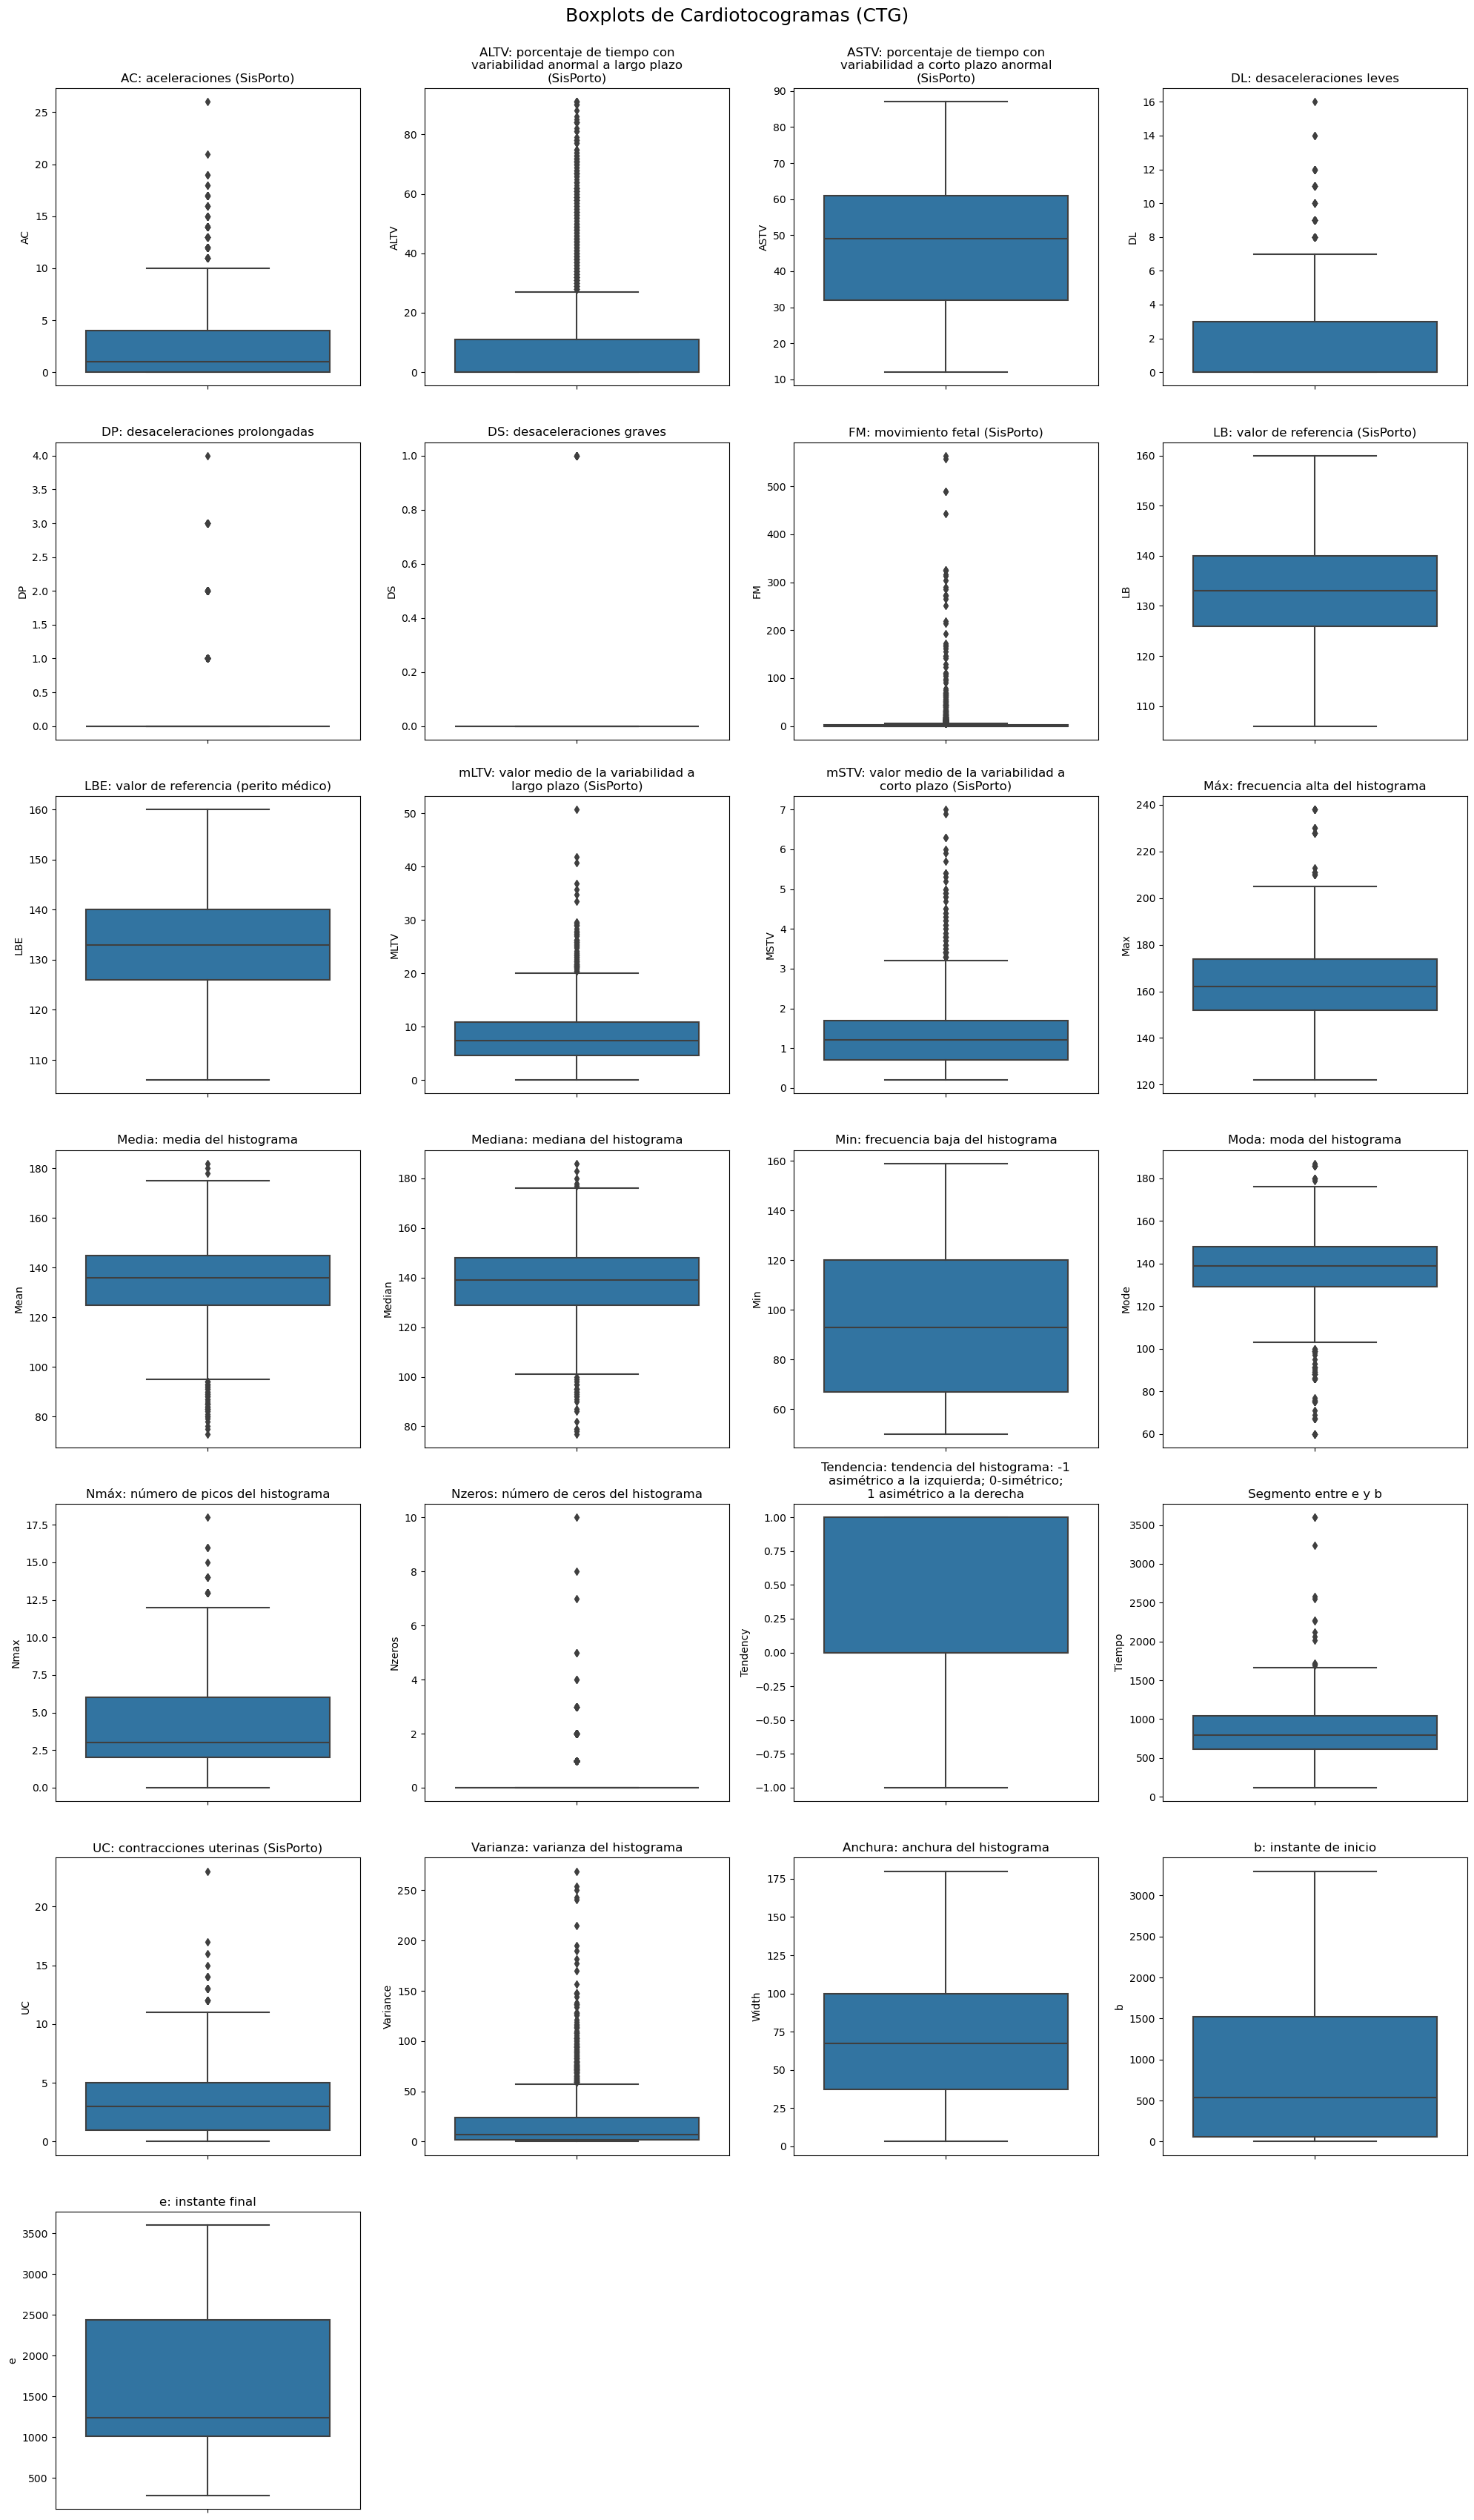

In [107]:
# Calcular el número de filas y columnas para el grid
num_cols = len(numeric_cols)
num_rows = (num_cols + 3) // 4  # Ajusta el número de columnas por fila según tu preferencia

# Crear el grid de subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=4, figsize=(20, 5 * num_rows))
axes = axes.flatten()  # Aplanar el array de ejes para facilitar la iteración

# Crear boxplots para cada columna numérica
for i, col in enumerate(numeric_cols):
    sns.boxplot(y=df[col], ax=axes[i])
    titulo = f"{descripciones.get(col, 'Descripción no encontrada')}"
    titulo = textwrap.fill(titulo, width=40)
    axes[i].set_title(titulo)

# Eliminar subplots vacíos si es necesario
if num_cols < len(axes):
    for j in range(num_cols, len(axes)):
        fig.delaxes(axes[j])

fig.suptitle("Boxplots de Cardiotocogramas (CTG)", fontsize=18)

plt.tight_layout(rect=[0, 0.01, 1, 0.98])
plt.show()

c:\Users\jgarc\miniconda3\envs\jcia\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
c:\Users\jgarc\miniconda3\envs\jcia\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


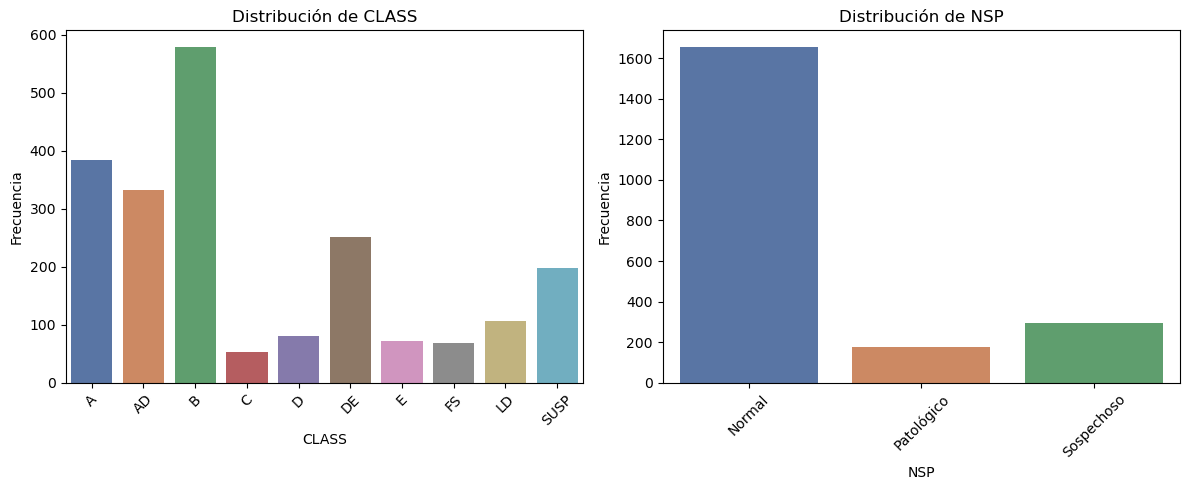

In [108]:
#Histogramas
# Configuración de la visualización
fig, axes = plt.subplots(1, len(categorical_cols), figsize=(12, 5))  # Distribuir horizontalmente

# Generar histogramas para cada variable categórica
for i, col in enumerate(categorical_cols):
    sns.countplot(data=df, x=col, ax=axes[i], palette="deep")
    axes[i].set_title(f"Distribución de {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frecuencia")
    axes[i].tick_params(axis='x', rotation=45)  # Rotar etiquetas para mejor legibilidad

plt.tight_layout()
plt.show()

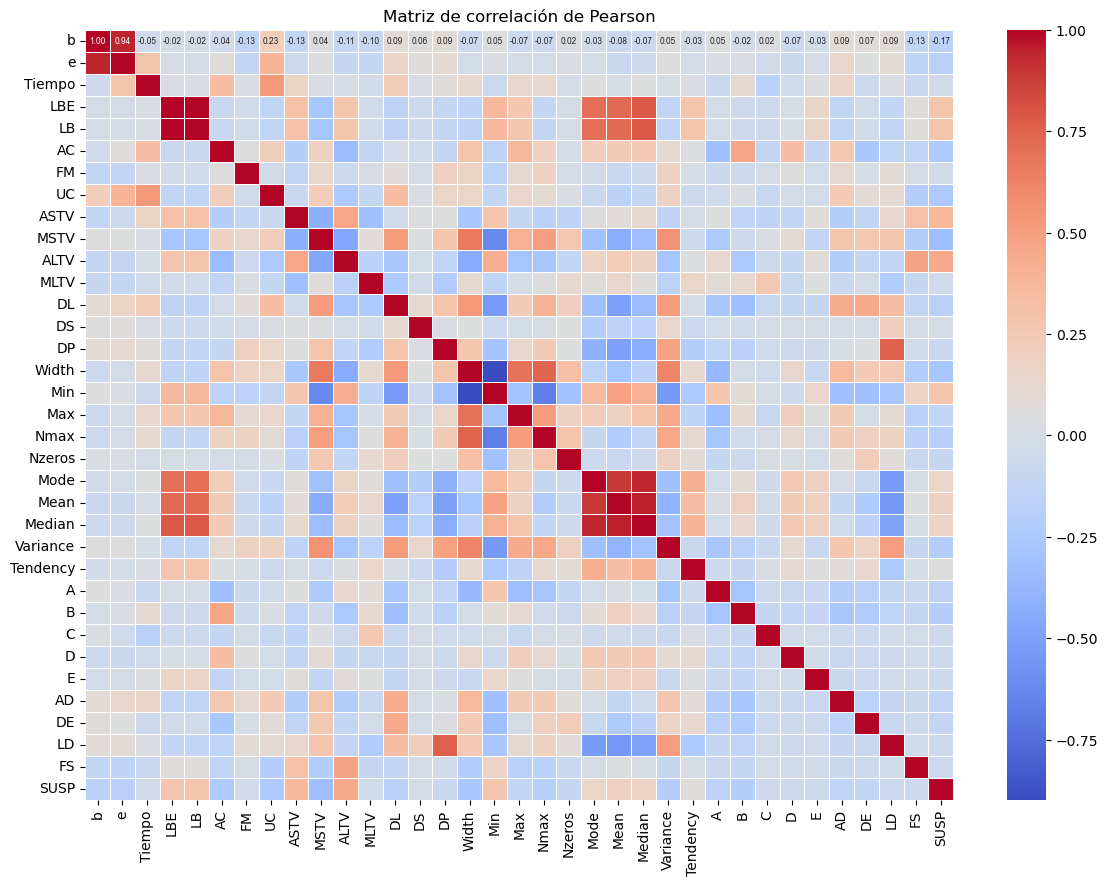

In [120]:
#Analisis de correlacion
# Calcular la matriz de correlación de Pearson
corr = df[numeric_cols_all].corr()

# Configurar la visualización
plt.figure(figsize=(14, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5,
            annot_kws={"fontsize": 6, "fontfamily": "arial"})
plt.title("Matriz de correlación de Pearson")
plt.show()
